<a href="https://colab.research.google.com/github/mahynski/chemometric-carpentry/blob/main/notebooks/1.4_Statistics_Background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
❓ ***Objective***: This notebook will provide some background in specific statistical ideas and tools.  For more details and information, please refer to the [NIST/SEMATECH e-Handbook of Statistical Methods](https://www.itl.nist.gov/div898/handbook/index.htm).

🔁 ***Remember***: You can always revisit this notebook for reference again in the future.  Ideas and best practices will be reinforced in future notebooks, so don't worry about remembering everything the first time you see something new.

🧑 Author: Nathan A. Mahynski

📆 Date: May 1, 2024

---

# $\chi^2$ Statistics

Recall that we stated many chemometric models, especially those used for authentication, follow a general pattern:

1. ⬇ Perform dimensionality reduction on a training set of data,
2. 💭 Draw a "bubble" around the test data in the lower dimensional space assuming it is normally distributed (usually using a Mahalanobis distance),
3. 📏 Use $\chi^2$ statistics to determine how "far" a sample can be from the center of the distribution and still be considered a class member.

What is the $\chi^2$ [distribution](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3666.htm) and how are we going to use it?  The definition from [Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution) is: If $Z_1$, ..., $Z_k$ are [independent](https://en.wikipedia.org/wiki/Independence_(probability_theory)), [standard normal](https://en.wikipedia.org/wiki/Standard_normal) random variables, then the sum of their squares:

$$
Q = \sum_{i=1}^k Z_i^2
$$

is distributed according to the $\chi^2$ distribution with k degrees of freedom. This is usually denoted as $Q \sim \chi^2(k)$ or $Q \sim \chi_k^2$.  More generally, it can be shown that if $Z_i \sim N(\mu_i, \sigma_i^2)$, then their "autoscaled" values follow a $\chi^2$ distribution:

$$
Q = \sum_{i=1}^k \left( \frac{Z_i - \mu_i}{\sigma_i} \right)^2 \sim \chi^2(k)
$$

## Example

In [1]:
# Select a certain number of degrees of freedom (dimensionality).
k = 20

In [13]:
import numpy as np

# Fix the RNG seed so the same random numbers are generated each time.
np.random.seed(42)

# This is what 1 sample would look like, i.e., one "row" in the "X" matrix.
np.random.normal(size=k)

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ])

In [5]:
# How many samples to draw?
N = 10000

Q = []
Z = np.zeros((N, k))
for i in range(N):
    # Generate k random numbers distributed according to Normal or  Gaussian
    # distribution.
    z = np.random.normal(size=k)
    Z[i,:] = z

    # Store the sum of squares.
    Q.append(np.sum(z**2))

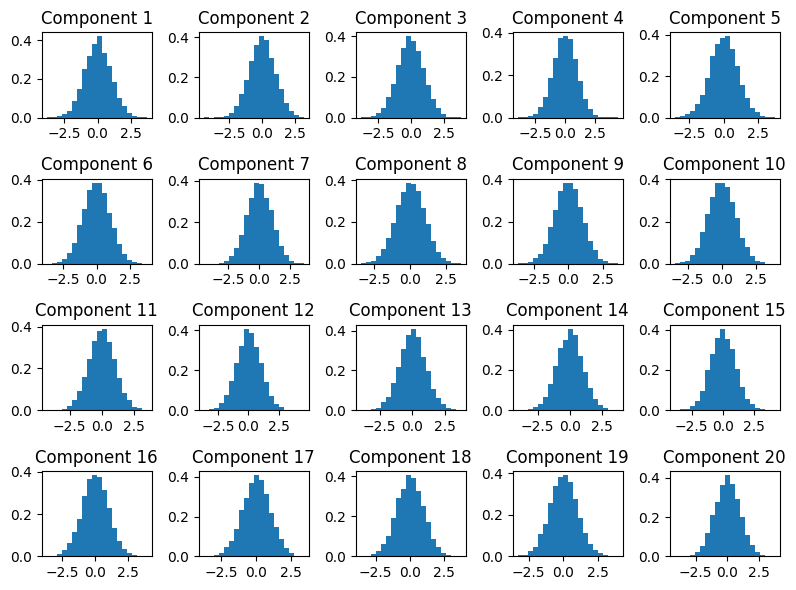

In [11]:
# Let's plot each component of Z so we can see that they are all random and
# normally distributed.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=5, nrows = int(np.ceil(k / 5)), figsize=(8,6))
for i, ax in enumerate(axes.ravel()):
    _ = ax.hist(Z[:,i], bins=20, density=True)
    _ = ax.set_title(f'Component {i+1}')
plt.tight_layout()

In [39]:
from scipy.stats import chi2

def plot_chi2(k, Q):
    fig, ax = plt.subplots(1, 1)

    # Plot the theoretical PDF
    x = np.linspace(chi2.ppf(0.0001, k), chi2.ppf(0.9999, k), 100)
    ax.plot(x, chi2.pdf(x, k), 'r-', lw=5, alpha=0.6, label=r'$\chi^2$({}) PDF'.format(k))

    # Plot the Q values we randomly created
    _ = ax.hist(np.array(Q), bins=50, density=True, label='Randomly Generated')

    plt.xlabel('Q')
    plt.ylabel('P(Q)')
    _ = plt.legend(loc='best')

    return ax

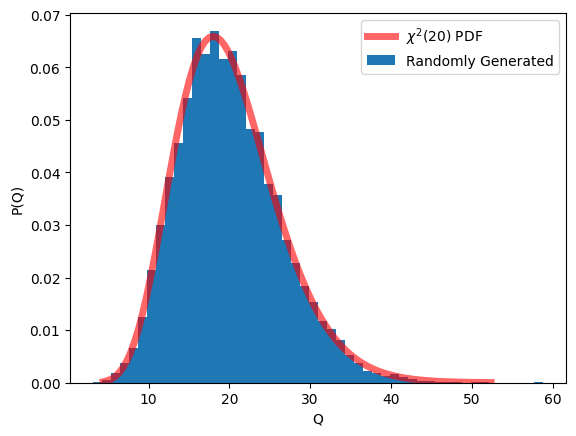

In [40]:
_ = plot_chi2(k, Q)

## Applications

Why does this matter?  Observe that in the general formula above, we are reducing the dimensionality of the data first.  This is usually done through PCA or a similar approach.  The result is data that "lives" in a lower $k$ dimensional space than the one we started with.  The scaled Euclidean distance squared, $D^2$, a given observation is from the center of this data is then given by

$$
D^2 = \sum_{i=1}^k \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2
$$

where $\bar{x}_i$ and $s_i$ are the estimated mean and sample standard deviation, respectively.  The [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) is $k$ dimensions generalizes this "standard score" distance, using a covariance matrix, which can be used to compute $D^2$.Clearly, $D^2 \sim \chi^2(k)$.  

Below is an example from [Wikipedia](https://en.wikipedia.org/wiki/Mahalanobis_distance) showing different different thresholds. More importantly, note that there are several different ways to compute the sample mean and covariance matrix since these can be very sensitive to outliers. The naive way is shown in purple ("non-robust"). Two "robust" methods, the MCD and MVE methods are shown for comparison.  This is related to the process of "cleaning" your data.  Often this involves detection and removal of outliers before modeling can begin so that non-robust methods can be used.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Mahalanobis-distance-location-and-scatter-methods.png/620px-Mahalanobis-distance-location-and-scatter-methods.png" wigth=50/>


⚠ We need to be careful about how we clean the data (remove outliers). 🗣 Here is some more vocabulary:
* Masking - this can occur when we assume there are less outliers than there actually are in the data. For example, if we are setting our limits based on the assumption that a single outlier is present when there are in fact more, these additional outliers may influence the cutoff value (increase it) to the point where it seems like there are NO outliers at all!
* Swamping - this can occur when we assume there are too many outliers in the data. For example, if we are testing for several outliers when there is, in fact, only a single outlier, then the critical distance will be reduced so that many truly inlier points are considered outliers

Some advice straight from [ITL @NIST](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm):
> "Due to the possibility of masking and swamping, it is useful to complement formal outlier tests with graphical methods. Graphics can often help identify cases where masking or swamping may be an issue. Swamping and masking are also the reason that many tests require that the exact number of outliers being tested must be specified.
>
> Also, masking is one reason that trying to apply a single outlier test sequentially can fail. For example, if there are multiple outliers, masking may cause the outlier test for the first outlier to return a conclusion of no outliers (and so the testing for any additional outliers is not performed)."

This is one reason many chemometric methods are accompanied by some graphical tools (more so than most machine learning methods). Certain chemometric tools have data cleaning built in, which is sometimes convenient. Again, this is an art 🎨.

Even after cleaning, we still need to determine he size of the "bubble" in step 2 (illustrated above) - this is often done by selecting a [Type I error rate](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors), $1-\alpha$. In [Hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_test), we are trying to determine if there is sufficient evidence to reject the "null hypothesis", that is, the baseline assumption that is the status quo.  In this application, the status quo is that a sample is expected to be similar to the known samples of an "authentic" class, for example.  A Type I error is when the null hypothesis is rejected, but it is actually true.  In other words, we are rejecting an "authentic" sample as being "inauthentic" even though it was, in fact, actually authentic.  This is set by the user, but typically values of $\alpha = 0.05$ or $\alpha = 0.01$ are selected.

👉 The critical distance we use to determine class membership is then computed from the "percent point function" of the $\chi^2$ distribution.  Recall, this is the limit at which a certain percent of the distribution fall below it.

Though there will be variations, this is a common theme in chemometric models.

In [47]:
alpha = 0.05

d2_crit = chi2.ppf(1 - alpha, df=k)
d2_crit

31.410432844230918

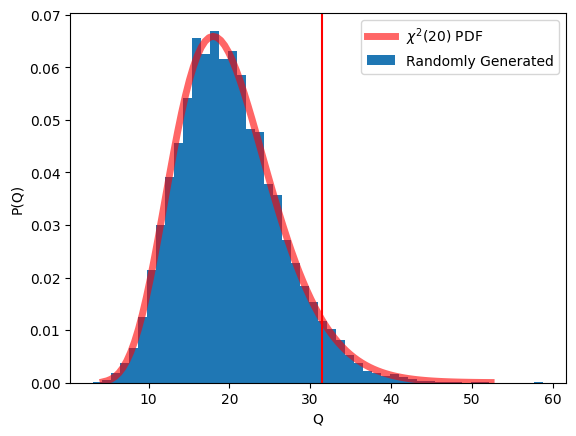

In [48]:
ax = plot_chi2(k, Q)
ax.axvline(d2_crit, color='red')

In [50]:
# Let's see how close we came to 1-alpha being below this cutoff in our sampled
# data.
np.sum(np.array(Q) < d2_crit) / len(Q)

0.9499

# Baseline Performance Metrics

In [ ]:
# n-1 vs. N in std dev
# R^2 def
# majority class
# TEFF vs acc etc

# TP, FP, alpha etc

# Rashomon sets